In [42]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Birth Weight Paradox

In [34]:
prior_smoking = 0.48
prior_birth_defect = 0.05
prior_birth_weight = 0.99
prior_mortality = 0.01

# Causal Model:
# Mortality <- Birth Weight <- Smoking -> Mortality <- Birth Defect -> Birth Weight

effect_birth_weight_on_mortality = -0.3
effect_smoking_on_birth_weight = -0.5
effect_smoking_on_mortality = 4
effect_birth_defect_on_mortality = 12
effect_birth_defect_on_birth_weight = -0.5

random.seed(42)

In [35]:
def noise():
    return (random.random() - 0.5) * 0.3

def limit(x):
    return min([max([x, 0]), 1])

def generate_sample():
    smoking = 1.0 if random.random() < prior_smoking else 0.0
    birth_defect = 1.0 if random.random() < prior_birth_defect else 0.0
    birth_weight = 1.0 if random.random() < prior_birth_weight else 0.8
    
    birth_weight += birth_weight * ((smoking * (effect_smoking_on_birth_weight + noise())))
    birth_weight += birth_weight * ((birth_defect * (effect_birth_defect_on_birth_weight + noise())))
    
    mortality = prior_mortality
    mortality += mortality * ((smoking * (effect_smoking_on_mortality + noise())))
    mortality += mortality * ((birth_defect * (effect_birth_defect_on_mortality + noise())))
    mortality += mortality * ((birth_weight * (effect_birth_weight_on_mortality + noise())))
    
    return [limit(x) for x in [smoking, birth_defect, birth_weight, mortality]]

data = [generate_sample() for _ in range(5000)]    
df = pd.DataFrame(data, columns=['smoking', 'birth_defect', 'birth_weight', 'mortality'])
df.head()

,smoking,birth_defect,birth_weight,mortality
0,0.0,1.0,0.570941,0.099428
1,1.0,1.0,0.179555,0.607513
2,1.0,0.0,0.351950,0.043412
3,0.0,0.0,1.000000,0.007689
4,0.0,0.0,1.000000,0.007232


In [36]:
corr = df.corr()
corr.style.background_gradient()

,smoking,birth_defect,birth_weight,mortality
smoking,1,0.0227547,-0.918886,0.323316
birth_defect,0.0227547,1,-0.322939,0.795456
birth_weight,-0.918886,-0.322939,1,-0.485726
mortality,0.323316,0.795456,-0.485726,1


In [37]:
print("mortality underweight smoking mother:", "%.2f" % df[(df['birth_weight'] < 1) & (df['smoking'] == 1)].mortality.mean())
print("mortality underweight non-smoking mother:", "%.2f" % df[(df['birth_weight'] < 1) & (df['smoking'] == 0)].mortality.mean())

mortality underweight smoking mother: 0.07
mortality underweight non-smoking mother: 0.09


Apparently mothers with underweight babies have a smaller mortality rate if they smoke, that's the birth weight paradox.

It's caused by the collider bias, birth weight is the collider. By conditioning on birth weight we add a spurious negative correlation between smoking and mortality, which bias the real effect of smoking on mortality

The thing is, if the baby is underweight because the mother smokes, it is less bad then when the baby is underweight because of a birth defect.

Looking from another perspective: if the baby is underweight and we find that the mother is a smoker, that explains away the low weight, reducing the probability it was caused by a more serious birth defect. OTOH if the mother doesn't smoke, then probably the baby is underweight for a more life-threatening issue.

So let's not condition on birth weight:

In [38]:
print("mortality smoking mother:", "%.2f" % df[df['smoking'] == 1].mortality.mean())
print("mortality non-smoking mother:", "%.2f" % df[df['smoking'] == 0].mortality.mean())

mortality smoking mother: 0.07
mortality non-smoking mother: 0.01


You can see that smoking mothers have a way bigger mortality rate that those who doesn't.

Now, if you do want to condition on birth weight, you have to control for birth defect:

In [39]:
print("mortality underweight smoking mother no-defect:", "%.2f" % df[(df['birth_weight'] < 1) & (df['smoking'] == 1) & (df['birth_defect'] == 0)].mortality.mean())
print("mortality underweight non-smoking mother no-defect:", "%.2f" % df[(df['birth_weight'] < 1) & (df['smoking'] == 0) & (df['birth_defect'] == 0)].mortality.mean())
print("")
print("mortality underweight smoking mother defect:", "%.2f" % df[(df['birth_weight'] < 1) & (df['smoking'] == 1) & (df['birth_defect'] == 1)].mortality.mean())
print("mortality underweight non-smoking mother defect:", "%.2f" % df[(df['birth_weight'] < 1) & (df['smoking'] == 0) & (df['birth_defect'] == 1)].mortality.mean())

mortality underweight smoking mother no-defect: 0.04
mortality underweight non-smoking mother no-defect: 0.01

mortality underweight smoking mother defect: 0.60
mortality underweight non-smoking mother defect: 0.11


## Simpson's Paradox

In [24]:
effect_exercise_on_cholesterol = -1.2
effect_age_on_cholesterol = 1.5

# Model:
# age -> cholesterol <- exercises <- age

ages = np.array(range(100, 500)) / 10
exercises = [ x / 5 * (1 + noise()) for x in ages ]
cholesterol = [ y // 10 * (3 + noise()) - x * (1 + noise()) for x, y in zip(exercises, ages) ]

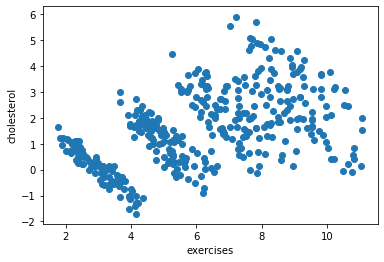

In [25]:
from matplotlib.patches import Ellipse

# Uncomment to see more or less the age groups
# for age_group in range(10, 50, 10):
#     exercises_for_age = exercises[age_group-10:age_group]
#     cholesterol_for_age = cholesterol[age_group-10:age_group]
#     circle = Ellipse((age_group / 6 + 1.5, age_group / 7 - 1.8), 2, 4 + age_group * 0.07, angle=35, color='r', fill=False, clip_on=False)
#     plt.gca().add_artist(circle)

plt.scatter(x = exercises, y = cholesterol)
plt.xlabel("exercises")
plt.ylabel("cholesterol")

plt.show()

Looking at the graph above it looks like the more you exercise, the higher your cholesterol is, so it exercising actually bad for your health? 

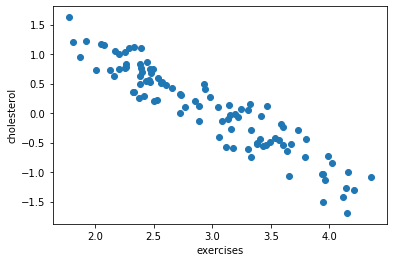

In [26]:
plt.scatter(x = exercises[0:100], y = cholesterol[0:100])
plt.xlabel("exercises")
plt.ylabel("cholesterol")
plt.show()

No, actually there is a confounder: age. If we take a slice of the data focused on some age group we can see that actually the more you exercise the smaller is your cholesterol. The thing is that with more age both your cholesterol increases and you tend to exercise more.

This is the Simpson's Paradox: grouped data shows a different trend from slices of the data.

### Back-Door Adjustment

As mentioned, if you just take the linear coefficient between exercises and cholesterol you'll find a positive correlation

In [27]:
# np.corrcoef(exercises, cholesterol)[0][1]

def linear_coef(x, y):
    x = np.array(x)
    A = np.array([ x, np.ones(len(x)) ])
    y = np.array(y)
    return np.linalg.lstsq(A.T, y, rcond=None)[0][0]

linear_coef(exercises, cholesterol)

0.3048588120619723

Instead, we can control for age by taking an average of coefficients in each age group

In [28]:
coefs = []
for age_group in range(10, 50, 10):
    coef = linear_coef(exercises[0:age_group], cholesterol[0:age_group]) # np.corrcoef(exercises[0:age_group], cholesterol[0:age_group])[0][1]
    coefs.append(coef)
np.mean(coefs)

-0.9999637499861551

Now you can see there is a negative correlation, as expected.

An even better approach is to use a multi linear regression and just take the calculated coefficient for exercise, because it will already be adjusted for age. Doing like this is also good because in many cases we don't know exactly how to split the groups

In [29]:
from sklearn.linear_model import LinearRegression

X = np.array([exercises, ages]).T
y = cholesterol

regressor = LinearRegression()
regressor.fit(X, y)

print(regressor.coef_[0])

-0.9834891987112377


The result is very close to the age groups average one